In [51]:
import pandas as pd
import numpy as np
from util import *
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pickle

In [2]:
train_data = pd.read_csv('../data/train/feature.csv', index_col=0)
train_label = pd.read_csv('../data/train/label.csv', index_col = 0)
train_data = na_rate(train_data)
train_data, train_label = datediff(train_data, train_label)

## NA Rate

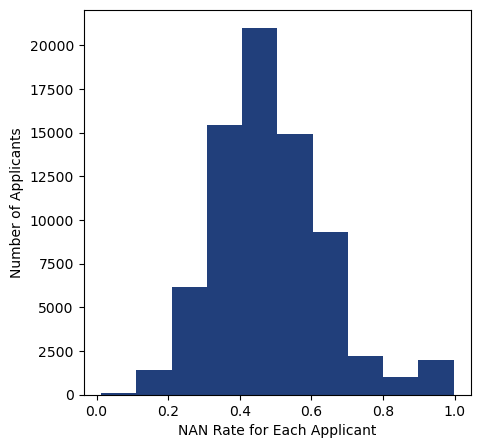

In [16]:
plt.figure(figsize = (5, 5))
plt.hist(train_data['na_rate'], color = '#213f7b')
plt.xlabel('NAN Rate for Each Applicant')
plt.ylabel('Number of Applicants')
plt.savefig('fig/na_rate.png', transparent = True, bbox_inches='tight')

## Label Count

In [25]:
label_cnt = list(train_label.groupby('DEFAULT_LABEL').count()['APPLICATION_DATE'])

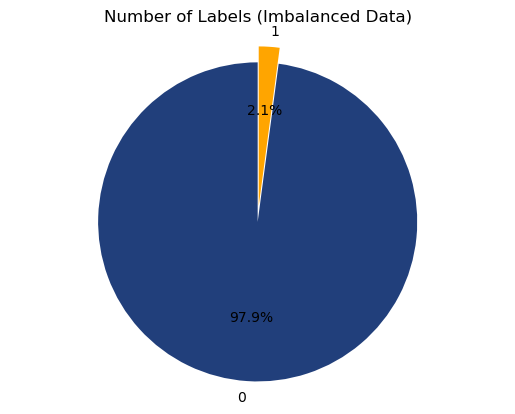

In [34]:
labels = '0', '1'
sizes = label_cnt
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig = plt.figure()
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',colors = ('#213f7b', 'orange'),
        shadow=False, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Number of Labels (Imbalanced Data)')
plt.savefig('fig/label_cnt.png', transparent = True)
plt.show()

## Cluster

In [37]:
train_fillna = train_data.fillna(train_data.mean())
kmeans = KMeans(n_clusters=10, random_state=0).fit(train_fillna.T)

In [47]:
train_cluster = train_fillna.T
train_cluster['label'] = kmeans.labels_
count_group = train_cluster.groupby('label').count()
list(count_group.iloc[:, 1])

[979, 1, 1, 2, 1, 4, 8, 1, 1, 4]

In [41]:
train_cluster_2 = train_cluster.loc[kmeans.labels_ == 0, :]
kmeans_2 = KMeans(n_clusters=10, random_state=0).fit(train_cluster_2)

In [48]:
train_cluster_2['label'] = kmeans_2.labels_
count_group_2 = train_cluster_2.groupby('label').count()
list(count_group_2.iloc[:, 1])

[852, 1, 1, 8, 1, 112, 1, 1, 1, 1]

In [49]:
train_cluster_3 = train_cluster_2.loc[kmeans_2.labels_ == 0, :]
kmeans_3 = KMeans(n_clusters=10, random_state=0).fit(train_cluster_3)

In [50]:
train_cluster_3['label'] = kmeans_3.labels_
count_group_3 = train_cluster_3.groupby('label').count()
list(count_group_3.iloc[:, 1])

/var/folders/57/93d17htn4fvf59qnk7npkv8m0000gn/T/ipykernel_929/1796488916.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_cluster_3['label'] = kmeans_3.labels_


[565, 1, 127, 1, 1, 1, 83, 1, 71, 1]

## Float Int Cluster

In [55]:
temp = train_data - np.floor(train_data)
int_feature = temp.loc[:, temp.max(axis = 0)==0].columns
float_feature = temp.loc[:, temp.max(axis = 0) >0].columns

train_float = train_data[float_feature].iloc[:, :-1]
train_float = train_float.fillna(train_float.mean())
train_float_g0 = train_float.loc[:, train_float.min(axis = 0)>=0]
train_float_l0 = train_float.loc[:, train_float.max(axis = 0)<=0].reset_index(drop = True)
train_float_gl0 = train_float.loc[:, (train_float.min(axis = 0)<0)*(train_float.max(axis = 0)>0)]

train_int = train_data[int_feature]
diff_columns = train_int.columns[train_int.max(axis = 0) != train_int.min(axis = 0)]
same_columns = train_int.columns[train_int.max(axis = 0) == train_int.min(axis = 0)]
train_int = train_int[diff_columns]
train_int = train_int.fillna(-1).reset_index(drop = True)

feature_dict = {'float_g0': list(train_float_g0.columns), 'float_gl0': list(train_float_gl0.columns), 
                'float_l0': list(train_float_l0.columns), 'float_feature': list(train_float.columns), 
                'int_feature': list(train_int.columns), 'na_rate':['na_rate'], 'constant': list(same_columns)}
with open('feature_columns.pkl', 'wb') as f:
    pickle.dump(feature_dict, f)

In [77]:
feature_dict = pickle.load(open('feature_columns.pkl', 'rb'))
x = list(feature_dict.keys())
y = [len(val) for val in feature_dict.values()]
sortidx = np.argsort(y)[::-1][1:]
x_new = np.array(x)[sortidx]
y_new = np.array(y)[sortidx]

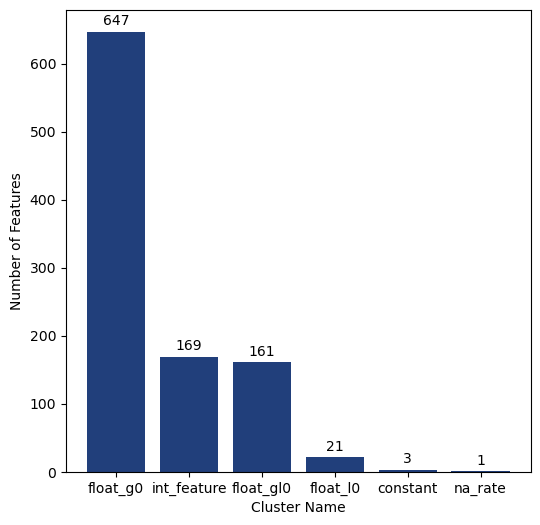

In [89]:
plt.figure(figsize = (6, 6))
plt.bar(x_new, y_new, color = '#213f7b')
for i in range(len(x_new)):
    plt.text(i, y_new[i]+10, y_new[i], ha = 'center')
plt.xlabel('Cluster Name')
plt.ylabel('Number of Features')
plt.savefig('fig/feature_cluster.png', transparent = True, bbox_inches = 'tight')
plt.show()